In [1]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import json

import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

from interpretability.grad_cam import GradCAM, GradCamPlusPlus
from Datasets.dataload import Path_Image_Preprocessing, Image_Preprocessing
from interpretability.Semantically_interpretable import Segmantically_Attributes
from utils import *

In [2]:
def imshow(img):
    """
    jupyter imshow
    """
    plt.figure(dpi=50)
    plt.axis('off')
    img = img[:,:,::-1] 	# transform image to rgb
    plt.imshow(img)
    plt.show()

## 1. Define the input images

In [3]:
# Load the images that have been aligned
image_path = "images/face1-alignment.jpg"
counter_face_path = "images/face2-alignment.jpg"

Text(0.5, 1.0, 'Counter Face')

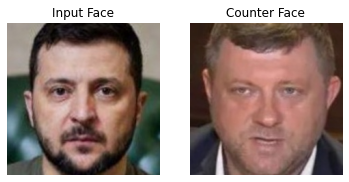

In [4]:
## Visualize the input image
image_V = Image.open(image_path)
counter_face_V = Image.open(counter_face_path)

plt.figure()

# Input face 
ax = plt.subplot(121)
plt.axis('off')
plt.imshow(image_V)
ax.set_title('Input Face')

# Counter face
ax = plt.subplot(122)
plt.axis('off')
plt.imshow(counter_face_V)
ax.set_title('Counter Face')

## 2. Load the networks and components

In [5]:
# Load Identification Network
recognition_net = get_network("VGGFace2")
if torch.cuda.is_available():
    recognition_net.cuda()
recognition_net.eval()
print("Load the identification net")

# Load Attribute Network
attribute_net = get_network(None, "./pre-trained/Face-Attributes2.pth")
if torch.cuda.is_available():
    attribute_net.cuda()
attribute_net.eval()
print("Load the attribute net")

seg_attr = Segmantically_Attributes(recognition_net, attribute_net, "GradCAM")

Load the identification net
Model parameters: ./pre-trained/Face-Attributes2.pth has been load!
Load the attribute net


## 3. Compute the heatmap

In [6]:
# Preproccessing
image1 = Path_Image_Preprocessing("VGGFace2", image_path).numpy()
image2 = Path_Image_Preprocessing("VGGFace2", counter_face_path).numpy()

In [7]:
seg_attr_interpretable1, index1, index2, attribute_id1, scores_attr1, mask1, mask2, counterfactual_map, attribute_map = seg_attr.topk_Identity_Segmantically_Attributes_Interpretable(image1, image2, 1, visualization = True)

In [8]:
def norm_image(image):
    """
    Normalization image
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

def generate_heatmap(image_input, mask):
    '''
    Save the heatmap of ones
    '''
    # Read image
    image = cv2.imread(image_input)
    # print(np.max(mask))
    masks = (mask * 255).astype(np.uint8)
    # masks = norm_image(mask).astype(np.uint8)
    # mask->heatmap
    heatmap = cv2.applyColorMap(masks, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap)
    # merge heatmap to original image
    cam = 0.5*heatmap + 0.5*np.float32(image)
    return cam.astype(np.uint8)

def cv2image(image):
    pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return pil_img

## 4. Visualize the ID map

In [9]:
ID_heatmap_visualization = cv2image(generate_heatmap(image_path, mask1))
Counter_ID_heatmap_visualization = cv2image(generate_heatmap(image_path, mask2))
CounterfactualMap = cv2image(generate_heatmap(image_path, counterfactual_map))

In [31]:
ID_heatmap_visualization.save("./images/results/Зеленский_Ht.jpg")
Counter_ID_heatmap_visualization.save("./images/results/Зеленский_Hf.jpg")
CounterfactualMap.save("./images/results/Зеленский_Hd.jpg")

Text(0.5, 1.0, 'Counterfactual MAP')

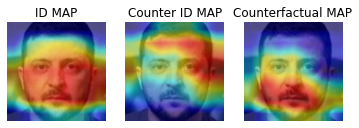

In [10]:
## Visualize the map
plt.figure()

# ID MAP
ax = plt.subplot(131)
plt.axis('off')
plt.imshow(ID_heatmap_visualization)
ax.set_title('ID MAP')

# Counter MAP
ax = plt.subplot(132)
plt.axis('off')
plt.imshow(Counter_ID_heatmap_visualization)
ax.set_title('Counter ID MAP')

# Counterfactual MAP
ax = plt.subplot(133)
plt.axis('off')
plt.imshow(CounterfactualMap)
ax.set_title('Counterfactual MAP')

## Visualize the Attribute Map

In [32]:
Gender = ["Male","Female"]
Age = ["Young","Middle Aged","Senior"]
Race = ["Asian","White","Black"]
Hair_color = ["Black Hair","Blond Hair","Brown Hair","Gray Hair","Unknown Hair"]

def imshow_attributes_heatmap(image_input, attr_idx, masks):
    '''
    Save the attributes heatmap
    '''
    num = masks.shape[0]

    attribute_name = []
    heatmap_image = []
    
    for i in range(0,num):
        # Choose the exist attribute
        if Face_attributes_name[i] in ["Gender","Age","Race","Hair_color"] or attr_idx[i] == 0:
            if Face_attributes_name[i] == "Gender":
                attr_name = Gender[attr_idx[i]]
            elif Face_attributes_name[i] == "Age":
                attr_name = Age[attr_idx[i]]
            elif Face_attributes_name[i] == "Race":
                attr_name = Race[attr_idx[i]]
            else:
                attr_name = Face_attributes_name[i]
            
            attribute_name.append(attr_name)
            heatmap_image.append(cv2image(generate_heatmap(image_input, masks[i])))
    plt.figure(figsize=(24,24))
    for i in range(len(attribute_name)):
        ax = plt.subplot(1, len(attribute_name), i+1)
        plt.axis('off')
        plt.imshow(heatmap_image[i])
        ax.set_title(attribute_name[i])

    return attribute_name, heatmap_image

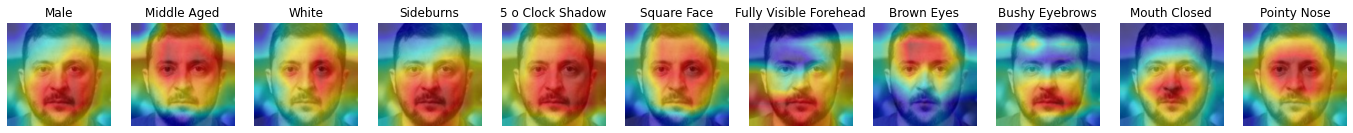

In [33]:
attribute_name, heatmap_image = imshow_attributes_heatmap(image_path, attribute_id1, attribute_map)

## Visualize the Joint Attribute MAP

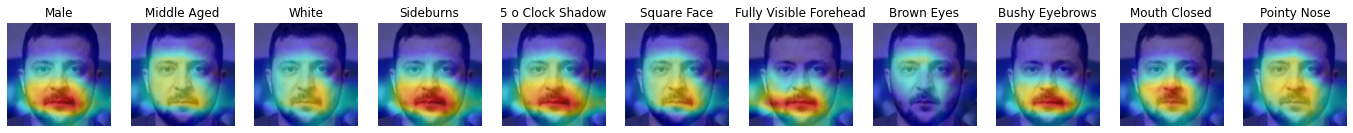

In [34]:
attribute_name, heatmap_image = imshow_attributes_heatmap(image_path, attribute_id1, seg_attr_interpretable1)

In [35]:
for i in range(len(attribute_name)):
    heatmap_image[i].save("./images/results/Joint_representation_MAP/{}.jpg".format(attribute_name[i]))